# MTF and Linearity

In [133]:
!python3 --version
import sys
sys.path

Python 3.7.10


['/Users/ajpfahnl/Google Drive/__Kadambi/MTF',
 '/Users/ajpfahnl/.vscode/extensions/ms-toolsai.jupyter-2021.5.702919634/pythonFiles',
 '/Users/ajpfahnl/.vscode/extensions/ms-toolsai.jupyter-2021.5.702919634/pythonFiles/lib/python',
 '/Users/ajpfahnl/miniconda3/envs/MTF/lib/python37.zip',
 '/Users/ajpfahnl/miniconda3/envs/MTF/lib/python3.7',
 '/Users/ajpfahnl/miniconda3/envs/MTF/lib/python3.7/lib-dynload',
 '',
 '/Users/ajpfahnl/.local/lib/python3.7/site-packages',
 '/Users/ajpfahnl/miniconda3/envs/MTF/lib/python3.7/site-packages',
 '/Users/ajpfahnl/miniconda3/envs/MTF/lib/python3.7/site-packages/IPython/extensions',
 '/Users/ajpfahnl/.ipython']

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rawpy
import numpy as np
import math
from scipy.fft import fft
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import cv2 as cv
%matplotlib inline
#plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [112]:
def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

class MTF():
    def __init__(self, img, center_offset = [0, 0], r_factor=1, raw=False, img_crop_params = None):
        rs_orig = np.array([30, 40, 50, 60, 75, 100, 125, 150, 175, 200, 225, 250])
        
        center = [center_offset[0] + img.shape[0]//2, center_offset[1] + img.shape[1]//2]
        if raw:
            center[0] += 10
            center[1] += 10
        
        self.center = center
        if img_crop_params is not None:
            x_nw, y_nw, w, h = img_crop_params
            self.img = img[x_nw:x_nw+h, y_nw:y_nw+w]
        else:
            self.img = img

        self.rs = np.array(rs_orig*r_factor, dtype="int")

        self.ppm = img.shape[1]/190
        self.cpq = 36

        self.freqs = []
        for i in range(len(self.rs)):
            self.freqs.append(self.cpq*2 / (self.rs[i]/self.ppm * math.pi/4))
    
    def find_arcs(self):
        img = self.img; rs = self.rs; center = self.center

        arcxs = []
        arcys = []
        arcvals = []
        for r in rs:
            arcval = []
            arcx = []
            arcy = []
            for i in range(-r, r+1):
                x = center[1] + i
                y = center[0] + int(np.sqrt(r**2 - i**2))
                arcx.append(x)
                arcy.append(y)
                arcval.append(img[y,x])
            arcxs.append(arcx)
            arcys.append(arcy)
            arcvals.append(arcval)
        self.arcvals, self.arcxs, self.arcys = arcvals, arcxs, arcys
        return arcvals, arcxs, arcys

    def display_arcs(self):
        img = self.img; center = self.center; arcvals = self.arcvals; arcxs = self.arcxs; arcys = self.arcys

        plt.gray()
        plt.imshow(img)
        plt.scatter([center[1]], [center[0]], marker='+')
        for i in range(len(arcxs)):
            plt.plot(arcxs[i], arcys[i])
        print(img.shape)

        print(f"{self.ppm} pixels per millimeter")
        print(f"{self.cpq} cycles per quadrant")
    
    def mtf(self, wave, Vb, Vw):
        Vmin = int(np.min(wave))
        Vmax = int(np.max(wave))
        C0 = (Vw - Vb)/(Vw + Vb)
        Cf = (Vmax - Vmin) / (Vmax + Vmin)
        return Cf/C0

    def arcvals_to_mtfs(self):
        arcvals = self.arcvals
        Vb = min([int(min(arc)) for arc in arcvals])
        Vw = max([int(max(arc)) for arc in arcvals])
        mtfs = []
        for i in range(len(arcvals)):
            mtfs.append(self.mtf(arcvals[i], Vb, Vw))
        return mtfs

(4020, 6024, 3) (4000, 6000, 3)


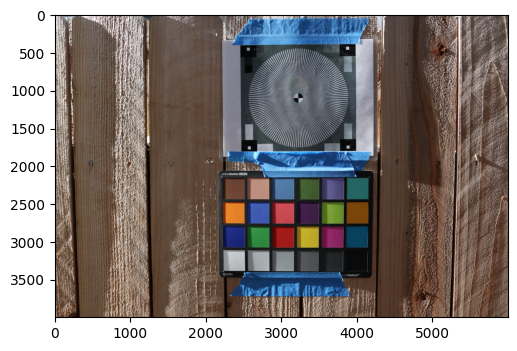

In [52]:
with rawpy.imread("canon_imgs/IMG_2580.CR2") as raw:
    image_raw_orig = raw.postprocess()
image_orig =  mpimg.imread("canon_imgs/IMG_2580.JPG")
print(image_raw_orig.shape, image_orig.shape)
plt.imshow(image_orig)

(1397, 1530)
8.052631578947368 pixels per millimeter
36 cycles per quadrant


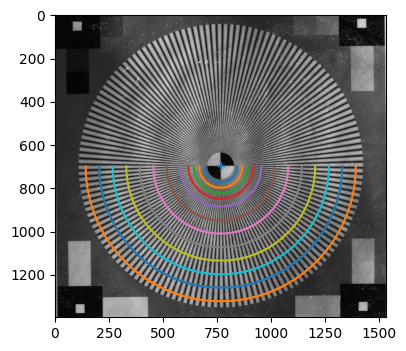

In [125]:
#image = rgb2gray(image_orig)
image = cv.cvtColor(image_orig,cv.COLOR_BGR2GRAY)
# params_IMG_2549 = (1250, 2100, 2000, 1600, 828, 960, 2.7)
# params_IMG_2551 = (1450, 2600, 850, 750, 390, 420, 1.2)
image = image[402:1799, 2458:3988]; params_IMG_2580 = ((0, 2) , 2.5)

params = params_IMG_2580
img_MTF = MTF(image, *params)
img_MTF.find_arcs()
img_MTF.display_arcs()

# corners = cv.goodFeaturesToTrack(img_MTF.img,2,0.1,10)
# corners = np.int0(corners)
# print(corners.reshape(-1, 2), corners.shape)
# plt.scatter(corners[0], corners[1])


(1397, 1530)
8.052631578947368 pixels per millimeter
36 cycles per quadrant


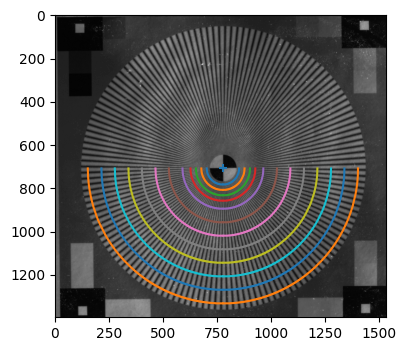

In [126]:
image_raw = cv.cvtColor(image_raw_orig,cv.COLOR_BGR2GRAY)
# params_IMG_2551_raw = (1450, 2600, 850, 750, 400, 430, 1.2)
# params_IMG_2580_raw = (400, 2400, 1600, 1400, (2+10, 25+10) , 2.5)
image_raw = image_raw[402:1799, 2458:3988]

img_raw_MTF = MTF(image_raw, *params, raw=True)
img_raw_MTF.find_arcs()
img_raw_MTF.display_arcs()

In [127]:
print("Cycles per millimeter")
print(img_MTF.freqs)

Cycles per millimeter
[9.842811806878984, 7.382108855159238, 5.905687084127391, 4.921405903439492, 3.9476517942028013, 2.9528435420636954, 2.3660605304997557, 1.9685623613757965, 1.6892697609060041, 1.4764217710318477, 1.313542500918014, 1.181137416825478]


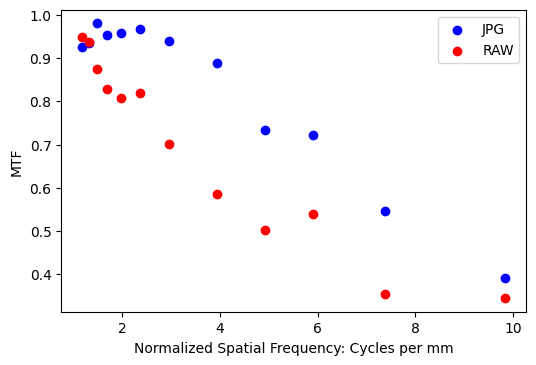

In [128]:
mtfs = img_MTF.arcvals_to_mtfs()
mtfs_raw = img_raw_MTF.arcvals_to_mtfs()
freqs = img_MTF.freqs

plt.scatter(freqs, mtfs, color='b', label="JPG")
plt.scatter(freqs, mtfs_raw, color='r', label="RAW")
plt.ylabel("MTF")
plt.xlabel("Normalized Spatial Frequency: Cycles per mm")
plt.legend()

Text(0.5, 0, 'Normalized Spatial Frequency: Cycles per mm')

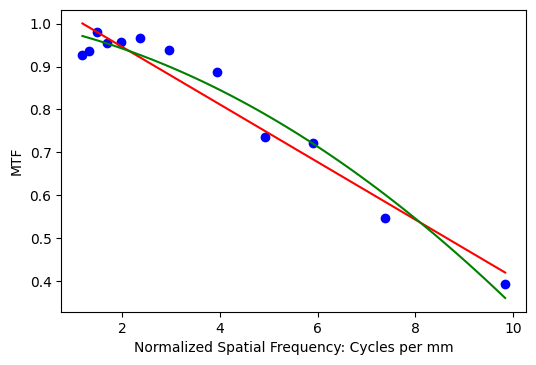

In [129]:
freqs = np.asarray(freqs)
mtfs = np.asarray(mtfs)
reg = LinearRegression().fit(freqs[:, np.newaxis], mtfs)
mtfs_predlinear = reg.predict(freqs[:, np.newaxis])

polymodel = make_pipeline(PolynomialFeatures(2), Ridge())
polymodel.fit(freqs[:, np.newaxis], mtfs)
x_plot = np.linspace(freqs[0], freqs[-1], 100)
mtfs_predquad = polymodel.predict(x_plot[:, np.newaxis])

plt.scatter(freqs, mtfs, color='b')
plt.plot(freqs, mtfs_predlinear, color='r', label='linear')
plt.plot(x_plot, mtfs_predquad, color='g', label='quad')
plt.ylabel("MTF")
plt.xlabel("Normalized Spatial Frequency: Cycles per mm")

In [130]:
class ImgLinearity():
    sRGB_R = np.array([115, 194, 98, 87, 133, 103,
                        214, 80, 193, 94, 157, 224, 
                        56, 70, 175, 231, 187, 8, 
                        243, 200, 160, 122, 85, 52])
    sRGB_G = np.array([82, 150, 122, 108, 128, 189,
                        126, 91, 90, 60, 188, 163, 
                        61, 148, 54, 199, 86, 133,
                        243, 200, 160, 122, 85, 52])
    sRGB_B = np.array([68, 130, 157, 67, 177, 170,
                        44, 166, 99, 108, 64, 46,
                        150, 73, 60, 31, 149, 161,
                        242, 200, 160, 121, 85, 52])

    def __init__(self, color_img, square_space = None, offset_x = None, offset_y = None):
        s = (color_img.shape[0], color_img.shape[1])
        img_R = np.zeros(s)
        img_G = np.zeros_like(img_R)
        img_B = np.zeros_like(img_R)
        img_R = img_color[:, :, 0]
        img_G = img_color[:, :, 1]
        img_B = img_color[:, :, 2]

        self.img_R = img_R
        self.img_G = img_G
        self.img_B = img_B

        square_space = int(s[1]//6)
        offset_y = square_space//2
        offset_x = square_space//2

        target_locs = np.zeros((4, 6, 2), dtype='int')
        for i in range(4):
            for j in range(6):
                target_locs[i, j, 1] = i*square_space + offset_x # x
                target_locs[i, j, 0] = j*square_space + offset_y # y 
        target_locs = target_locs.reshape((24, 2))

        self.target_locs = target_locs

    def extract_actual(self, box=None):
        target_locs = self.target_locs
        R_actual = np.zeros(24)
        G_actual = np.zeros(24)
        B_actual = np.zeros(24)

        if box == None:
            R_actual = self.img_R[target_locs[:, 1], target_locs[:, 0]]
            G_actual = self.img_G[target_locs[:, 1], target_locs[:, 0]]
            B_actual = self.img_B[target_locs[:, 1], target_locs[:, 0]]
        else:
            for n, (i, j) in enumerate(zip(target_locs[:, 1], target_locs[:, 0])):
                R_actual[n] = np.average(self.img_R[i:i+box, j:j+box])
                G_actual[n] = np.average(self.img_G[i:i+box, j:j+box])
                B_actual[n] = np.average(self.img_B[i:i+box, j:j+box])

        self.R_actual = R_actual
        self.G_actual = G_actual
        self.B_actual = B_actual

    def linregress(self, x, y):
        reg = LinearRegression().fit(x[:, np.newaxis], y)
        return reg.predict(x[:, np.newaxis])

    def plot(self):
        fig, axs = plt.subplots(1,3)
        axs[0].scatter(self.sRGB_R, self.R_actual, color='r')
        axs[0].plot(self.sRGB_R, self.linregress(self.sRGB_R, self.R_actual), color='k')
        axs[0].set_title("Red")

        axs[1].scatter(self.sRGB_G, self.G_actual, color='g')
        axs[1].plot(self.sRGB_G, self.linregress(self.sRGB_G, self.G_actual), color='k')
        axs[1].set_title("Green")

        axs[2].scatter(self.sRGB_B, self.B_actual, color='b')
        axs[2].plot(self.sRGB_B, self.linregress(self.sRGB_B, self.B_actual), color='k')
        axs[2].set_title("Blue")

        [ax.set_xlabel('Ideal sRGB') for ax in axs]
        [ax.set_ylabel('Measured Intensity') for ax in axs]

        fig.tight_layout()
        fig.set_figwidth(15)

(4000, 6000, 3)


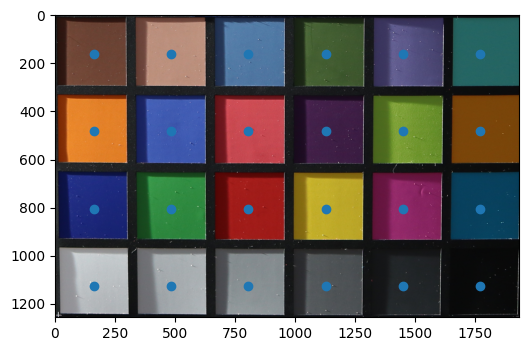

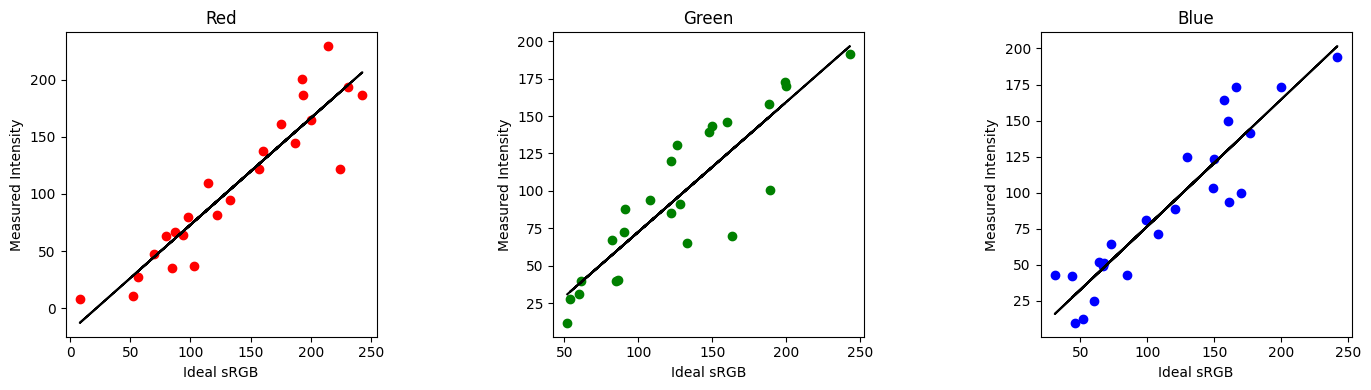

In [131]:
img_color = mpimg.imread("canon_imgs/IMG_2580.JPG")
print(img_color.shape)
img_color = img_color[2146:3403, 2212:4146, :]
plt.imshow(img_color)
iml = ImgLinearity(img_color)
plt.scatter(iml.target_locs[:, 0], iml.target_locs[:, 1])
iml.extract_actual(box=20)
iml.plot()

(4020, 6024, 3)


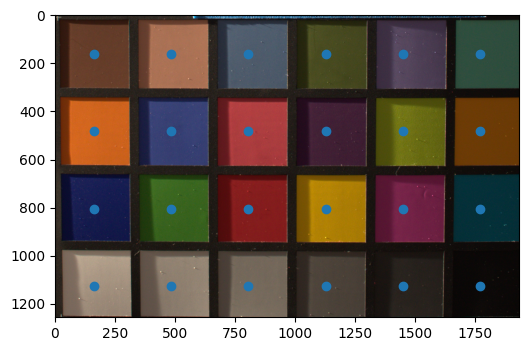

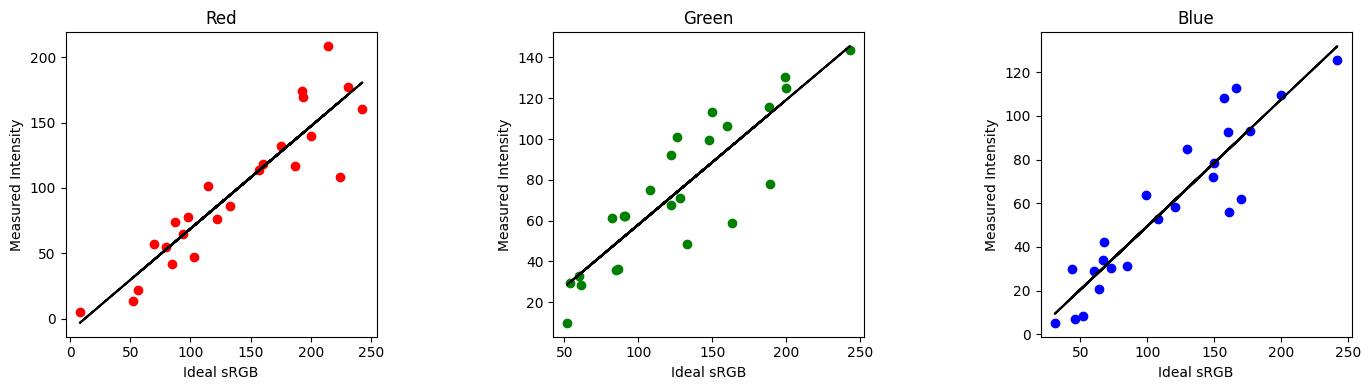

In [132]:
with rawpy.imread("canon_imgs/IMG_2580.CR2") as raw:
    img_color = raw.postprocess()
print(img_color.shape)
img_color = img_color[2146:3403, 2212:4146, :]
plt.imshow(img_color)
iml = ImgLinearity(img_color)
plt.scatter(iml.target_locs[:, 0], iml.target_locs[:, 1])
iml.extract_actual(box=20)
iml.plot()